In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import matplotlib.pyplot as plt

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [3]:
FEATURES_PATH = '/export/livia/home/datasets/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = '/export/livia/home/datasets/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = '/export/livia/home/datasets/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [5]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [5]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [6]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

### 1. 4. 2 Reconstruction de la base de données

In [6]:
train_images = np.concatenate([ raf_db['images_gender']['male'],
                                raf_db['images_gender']['female'],
                                raf_db['images_race']['caucasian'],
                                raf_db['images_race']['asian'],
                                raf_db['images_race']['african']
])

train_labels = np.concatenate([ raf_db['labels_gender']['male'],
                                raf_db['labels_gender']['female'],
                                raf_db['labels_race']['caucasian'],
                                raf_db['labels_race']['asian'],
                                raf_db['labels_race']['african']
])

## 2. Apprentissage de VGG19 sans fine tuning

In [4]:
# Instantiate the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top of the VGG19 baseline model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model pre-trained layers (so that we do not lose their weights)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpointsv2'
checkpoint_file = checkpoint_dir + '/best_vanilla_VGG19.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [7]:
# Train the model
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/100
614/614 [==============================] - 63s 85ms/step - loss: 1.9311 - accuracy: 0.4986 - val_loss: 1.1057 - val_accuracy: 0.6024
Epoch 2/100
614/614 [==============================] - 45s 74ms/step - loss: 0.9794 - accuracy: 0.6449 - val_loss: 1.0643 - val_accuracy: 0.6113
Epoch 3/100
614/614 [==============================] - 46s 74ms/step - loss: 0.8025 - accuracy: 0.7101 - val_loss: 0.9395 - val_accuracy: 0.6592
Epoch 4/100
614/614 [==============================] - 46s 75ms/step - loss: 0.6457 - accuracy: 0.7723 - val_loss: 0.7018 - val_accuracy: 0.7448
Epoch 5/100
614/614 [==============================] - 46s 74ms/step - loss: 0.5051 - accuracy: 0.8235 - val_loss: 0.6195 - val_accuracy: 0.7686
Epoch 6/100
614/614 [==============================] - 46s 75ms/step - loss: 0.3999 - accuracy: 0.8632 - val_loss: 0.5764 - val_accuracy: 0.7894
Epoch 7/100
614/614 [==============================] - 46s 75ms/step - loss: 0.3064 - accuracy: 0.8964 - val_loss: 0.4313 - val_ac

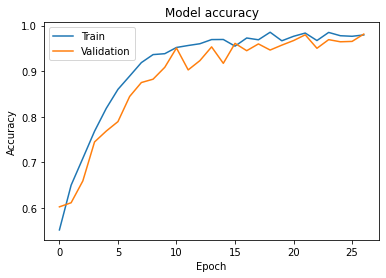

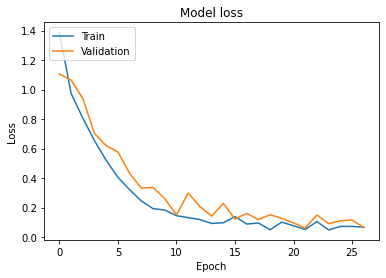

In [8]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()